# Differentiable beamforming for ultrasound autofocusing


In this tutorial we will implement a basic differential beamformer. We will use a gradient descent method to minimize a pixelwise common midpoint phase error to estimate a speed of sound map. The algorithm is slightly simplified, loss is computed without patching. 

For more information we would like to refer you to the original research [project page](https://waltersimson.com/dbua/) of the differential beamformer for ultrasound autofocusing (DBUA) [paper](https://doi.org/10.1007/978-3-031-43999-5_41):
- Simson, W., Zhuang, L., Sanabria, S.J., Antil, N., Dahl, J.J., Hyun, D. (2023). Differentiable Beamforming for Ultrasound Autofocusing. Medical Image Computing and Computer Assisted Intervention (MICCAI)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/dbua.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/dbua.ipynb)
&nbsp;
[![Hugging Face dataset](https://img.shields.io/badge/Hugging%20Face-Dataset-yellow?logo=huggingface)](https://huggingface.co/datasets/zeahub/circular_inclusion_simualation)

‼️ **Important:** This notebook is optimized for **GPU/TPU**. Code execution on a **CPU** may be very slow.

If you are running in Colab, please enable a hardware accelerator via:

**Runtime → Change runtime type → Hardware accelerator → GPU/TPU** 🚀.

In [ ]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["ZEA_DISABLE_CACHE"] = "1"
os.environ["ZEA_LOG_LEVEL"] = "INFO"

In [3]:
import time
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops

import zea
from zea import File, init_device
from zea.visualize import set_mpl_style
from zea.io_lib import matplotlib_figure_to_numpy, save_to_gif
from zea.backend.optimizer import adam
from zea.backend.autograd import AutoGrad
from zea.ops import (
    TOFCorrection,
    CommonMidpointPhaseError,
    PatchedGrid,
    EnvelopeDetect,
    Normalize,
    DelayAndSum,
    LogCompress,
)

zea: Using backend 'jax'


2026-02-13 09:17:53.217932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 09:17:53.227297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770974273.238000    7446 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770974273.241097    7446 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770974273.249424    7446 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
init_device(verbose=False)
set_mpl_style()

2026-02-13 09:17:56.249141: W external/xla/xla/service/platform_util.cc:211] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


## Load dataset 
First let's load a dataset. In this case a circular inclusion in an isoechoic medium, simulated in [k-Wave](http://www.k-wave.org/) and stored to [zea data format](../../data-acquisition.rst). It will automatically load from Hugging Face.

In [5]:
file_path = "hf://zeahub/simulations/circular_inclusion_simulation.hdf5"
file = File(file_path)
data_frame = file.load_data(data_type="raw_data")
probe = file.probe()

circular_inclusion_simulation.hdf5:   0%|          | 0.00/308M [00:00<?, ?B/s]

Now let's set up a field of view and a pixelwise loss function. We also select a grid of points where we will be calculating the loss. This grid is more an indication of how many points we consider per  step as we resample them every iteration in the field of view.

In [6]:
probe_geometry = probe.probe_geometry

xlims = (-15e-3, 15e-3)
x_min, x_max = xlims
zlims = (0e-3, 30e-3)
z_min, z_max = zlims
width, height = xlims[1] - xlims[0], zlims[1] - zlims[0]
wavelength = 1540 / probe.center_frequency

Nx = 25
Nz = 25
f_number = 0.7
scan = file.scan(
    xlims=xlims,
    zlims=zlims,
    grid_size_x=Nx,
    grid_size_z=Nz,
)

LossPipeline = zea.Pipeline(
    [
        zea.ops.PatchedGrid(
            [
                zea.ops.TOFCorrection(),
                zea.ops.CommonMidpointPhaseError(),
            ],
            num_patches=Nx * Nz,
        ),
    ],
    jit_options="pipeline",
)
parameters = LossPipeline.prepare_parameters(probe, scan)
parameters["f_number"] = f_number

zea: WARNING No initial times provided, using zeros
zea: WARNING No transmit origins provided, using zeros
zea: WARNING No azimuth angles provided, using zeros


## Set up SOS grid
Here we define the grid of sound speed voxels that will be optimized.


In [7]:
x_sos_grid = np.linspace(x_min, x_max, 40)
z_sos_grid = np.linspace(z_min, z_max, 40)
initial_sound_speed = 1460
sos_grid = initial_sound_speed * np.ones((x_sos_grid.shape[0], z_sos_grid.shape[0]))

## Set up optimizer
Here we define the optimization schedule parameters.



In [8]:
num_iterations = 200
step_size = 1

In [9]:
init_fn, update_fn, get_params_fn = adam(step_size)
opt_state = init_fn(sos_grid)

## Setup complete loss function
Here we combine the pixelwise loss with some vertical and horizontal regularizers. 
Furthermore, we introduce some helper functions for the optimization loop.

In [10]:
def loss_fn(
    sos_grid,
    x_sos_grid,
    z_sos_grid,
    LossPipeline,
    parameters,
    data_frame,
    flatgrid,
):
    dx_sos = x_sos_grid[1] - x_sos_grid[0]
    dz_sos = z_sos_grid[1] - z_sos_grid[0]
    parameters["flatgrid"] = flatgrid
    out = LossPipeline(
        data=data_frame,
        sos_grid=sos_grid,
        x_sos_grid=x_sos_grid,
        z_sos_grid=z_sos_grid,
        **parameters,
    )
    metric = out["data"]
    metric_safe = ops.nan_to_num(metric, nan=0.0)
    metric_loss = ops.mean(metric_safe)
    tvx = ops.mean(ops.square(ops.diff(sos_grid, axis=0)))
    tvz = ops.mean(ops.square(ops.diff(sos_grid, axis=1)))
    variation_loss = (tvx + tvz) * 1e2 * dx_sos * dz_sos
    total_loss = metric_loss + variation_loss
    return total_loss


loss_fn_caller = AutoGrad()
loss_fn_caller.set_function(loss_fn)


def compute_gradients(sos_grid, data_frame, flatgrid):
    kwargs = dict(
        x_sos_grid=x_sos_grid,
        z_sos_grid=z_sos_grid,
        LossPipeline=LossPipeline,
        parameters=parameters,
        data_frame=data_frame,
        flatgrid=flatgrid,
    )
    grad, loss = loss_fn_caller.gradient_and_value(sos_grid, **kwargs)

    return grad, loss


def apply_gradients(opt_state, grad):
    new_sos_grid, m, v, i = update_fn(grad, opt_state)
    new_opt_state = (new_sos_grid, m, v, i)
    return new_sos_grid, new_opt_state


def resample_grid(parameters, xlims, zlims):
    seed_generator = keras.random.SeedGenerator(int(time.time() * 1e6) % (2**32 - 1))
    n_pix = parameters["flatgrid"].shape[0]
    x = keras.random.uniform(shape=(n_pix,), minval=xlims[0], maxval=xlims[1], seed=seed_generator)
    y = ops.zeros_like(x)
    z = keras.random.uniform(
        shape=(n_pix,), minval=zlims[0] + 5e-3, maxval=zlims[1], seed=seed_generator
    )

    coords = ops.stack([x, y, z], axis=-1)
    return coords

## Make Visualisation Pipelines
We can now construct pipelines for the loss map and the B-mode image for visualization.

In [11]:
grid_size_x = int(width / (0.5 * wavelength) / 4) + 1
grid_size_z = int(height / (0.5 * wavelength) / 4) + 1
gridplot = file.scan(
    xlims=xlims,
    zlims=zlims,
    grid_size_x=grid_size_x,
    grid_size_z=grid_size_z,
)
LossplotPipeline = zea.Pipeline(
    [
        PatchedGrid(
            [TOFCorrection(), CommonMidpointPhaseError()],
            num_patches=(grid_size_z) * (grid_size_x),
        ),
    ],
    jit_options="pipeline",
)
ImageplotPipeline = zea.Pipeline(
    [
        PatchedGrid(
            [TOFCorrection(), DelayAndSum()],
            num_patches=grid_size_x * grid_size_z,
        ),
        EnvelopeDetect(),
        Normalize(),
        LogCompress(),
    ],
    jit_options="pipeline",
)

parametersplot = LossplotPipeline.prepare_parameters(probe, gridplot)
parametersplot["demodulation_frequency"] = parameters["demodulation_frequency"]
parametersplot["f_number"] = f_number

zea: WARNING No initial times provided, using zeros
zea: WARNING No transmit origins provided, using zeros
zea: WARNING No azimuth angles provided, using zeros


## Iterative optimization loop

Here we iteratively update the sound speed grid to minimze the common midpoint phase error.

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: [zea.Pipeline] Error in operation 'PatchedGrid': [zea.Pipeline] Error in operation 'TOFCorrection': calculate_delays_grid() takes 10 positional arguments but 12 were given

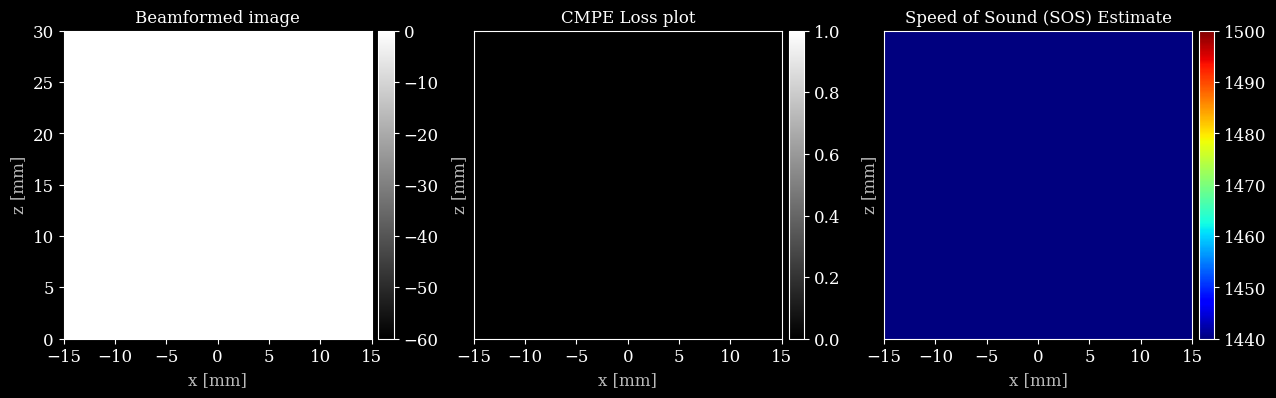

In [12]:
viz_frames = []

fig, (ax_bmode, ax_lossmap, ax_img) = plt.subplots(
    1,
    3,
    figsize=(15, 4),
    dpi=100,
)

extent = [
    x_sos_grid.min() * 1000,
    x_sos_grid.max() * 1000,
    z_sos_grid.min() * 1000,
    z_sos_grid.max() * 1000,
]
bmodeim = ax_bmode.imshow(
    np.zeros((grid_size_x, grid_size_z)),
    extent=extent,
    cmap="gray",
    vmin=-60,
    vmax=0,
)
lossim = ax_lossmap.imshow(
    np.zeros((grid_size_x, grid_size_z)),
    extent=extent,
    cmap="gray",
    vmin=0,
    vmax=1,
)
im = ax_img.imshow(
    np.zeros((grid_size_x, grid_size_z)),
    extent=extent,
    cmap="jet",
    origin="lower",
)
im.set_clim(1440, 1500)

ax_bmode.set_title("Beamformed image")
ax_bmode.set_xlabel("x [mm]")
ax_bmode.set_ylabel("z [mm]")

ax_lossmap.set_title("CMPE Loss plot")
ax_lossmap.set_xlabel("x [mm]")
ax_lossmap.set_ylabel("z [mm]")
ax_lossmap.set_yticks([])

ax_img.set_title("Speed of Sound (SOS) Estimate")
ax_img.set_xlabel("x [mm]")
ax_img.set_ylabel("z [mm]")
ax_img.invert_yaxis()
ax_img.set_yticks([])

fig.colorbar(bmodeim, ax=ax_bmode, fraction=0.05, pad=0.02)
fig.colorbar(lossim, ax=ax_lossmap, fraction=0.05, pad=0.02)
fig.colorbar(im, ax=ax_img, fraction=0.05, pad=0.02)

for i in trange(num_iterations, desc="Epochs"):
    flatgrid = resample_grid(parameters, xlims, zlims)
    grad, loss = compute_gradients(sos_grid, data_frame, flatgrid)
    sos_grid, opt_state = apply_gradients(opt_state, grad)
    if i % 5 == 0 & i == 0:
        bmode = ImageplotPipeline(
            data=data_frame,
            sos_grid=sos_grid,
            x_sos_grid=x_sos_grid,
            z_sos_grid=z_sos_grid,
            **parametersplot,
        )["data"][0].reshape(grid_size_x, grid_size_z)

        lossimage = LossplotPipeline(
            data=data_frame,
            sos_grid=sos_grid,
            x_sos_grid=x_sos_grid,
            z_sos_grid=z_sos_grid,
            **parametersplot,
        )["data"][0].reshape(grid_size_x, grid_size_z)

        bmodeim.set_data(bmode)
        lossim.set_data(lossimage)
        im.set_data(np.array(sos_grid).T)
        viz_frames.append(matplotlib_figure_to_numpy(fig))

plt.close(fig)
save_to_gif(viz_frames, "sos_optim.gif", shared_color_palette=True, fps=10)

![Speed of sound optimization progress](sos_optim.gif)